# Jupyter intro

### Useful shortcuts:
- Shift + Tab - function tooltip
- Shift + Tab + Tab - more detailed function info
- Tab - autocomplete list
- Shift + Enter - run cell

# Pandas intro

### Load all libraries needed

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn # for prettier plots, probably need to install it => conda install seaborn
%matplotlib inline

### Load datasets
All datasets are complete, there is no holes in them. Time represents number of hours from 2005-01-01.

In [31]:
with open('weather.pickle', 'rb') as file:
    weather = pickle.load(file)
with open('smog.pickle', 'rb') as file:
    smog = pickle.load(file)
    # smog -> dictionary, key is station number as string ex.
    # smog['6']['data']

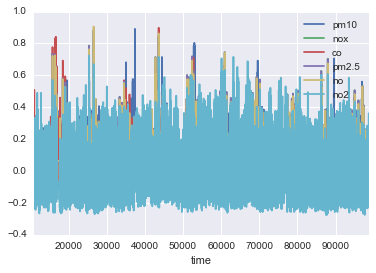

In [5]:
smog['6']['data'].plot(x='time')

#### About normalization
Datasets are also normalized.
To convert data back to original form use:
$$o = d \cdot (o_{max} - o_{min}) + o_{mean}$$
```python
# Ex.
smog_origin = smog[STATION]['data'] * (smog[STATION]['max'] - smog[STATION]['min']) + smog[STATION]['mean']
```

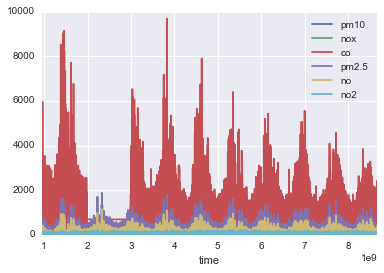

In [6]:
smog_origin = smog['6']['data'] * (smog['6']['max'] - smog['6']['min']) + smog['6']['mean']
smog_origin.plot(x='time')

### Useful functions for unnormalizing data

In [7]:
def unnormalize(x, min_value, max_value, mean_value):
    return x * (max_value - min_value) + mean_value

In [8]:
def unnormalize_smog(x, station, substance):
    return unnormalize(x, smog[station]['min'][substance], smog[station]['max'][substance], smog[station]['mean'][substance])

In [9]:
def unnormalize_weather(x, what):
    return unnormalize(x, weather['min'][what], weather['max'][what], weather['mean'][what])

### For converting `time` column

In [10]:
def hours_to_date(x):
    base_time = pd.to_datetime('2005-01-01').to_datetime64().astype('int64')
    return pd.to_datetime(base_time // 1000000000 + x * 3600, unit='s')

In [11]:
def date_to_hours(date):
    if type(date) == type(''):
        date = pd.to_datetime(date)
    base_date = pd.to_datetime('2005-01-01').to_datetime64().astype('int64')
    return int((date.to_datetime64().astype('int64') - base_date) // 3600000000000)

# Scikit learn - Regression

In [12]:
from sklearn import linear_model

# Actual work
We will work on `weather_smog` dataset, but first we need to split it on train, validation, test sets. We will always train our model on train set then try to evaluate it on validation set and fine-tune hyper-parameters. At the very end we will check our model on test set.

In [32]:
weather_smog = pd.merge(weather['data'], smog['7']['data'], on='time') # for now we only use station 7

In [33]:
def create_and_fit_model(X, y):
    model = linear_model.LinearRegression(n_jobs=8, normalize=True)
    model.fit(X, y)
    return model

In [34]:
def plot_fitted_data(model, X, y, begin=0, end=100, station='7', substance='co'):
    prediction = model.predict(X)
    plt.figure(figsize=(16, 9))
    tmp = X[:]
    tmp['target'] = y
    tmp['pred'] = prediction
    tmp = tmp.sort_values(by='time')
    plt.plot(tmp['time'][begin:end], unnormalize_smog(tmp['target'], station, substance)[begin:end])
    plt.plot(tmp['time'][begin:end], unnormalize_smog(tmp['pred'], station, substance)[begin:end])
    plt.show()

In [35]:
def plot_dependency(model, feature_list):
    best_n = list(zip(model.coef_, feature_list))
    best_n.sort(key=lambda x: -abs(x[0]))
    best_n = list(filter(lambda x: abs(x[0]) > 0.1, best_n))[:15]
    index = np.arange(len(best_n))
    bar_width = 0.35
    plt.figure(figsize=(16, 9))
    plt.bar(index, list(map(lambda x: x[0], best_n)), bar_width)
    plt.xticks(index + bar_width / 2, list(map(lambda x: x[1], best_n)))
    plt.tight_layout()
    plt.show()

## Prepare targets for all data

In [36]:
time_span_h = 24
basic_features = list(weather_smog.columns)

for feature in basic_features:
    if feature == 'time': continue
    target = feature + '-target'
    weather_smog[target] = weather_smog[feature].shift(-1)

timeless_features = basic_features
timeless_features.remove('time')
for h in range(1, time_span_h + 1):
    new_features = list(map(lambda x: x + '-' + str(h) + 'h', timeless_features))
    weather_smog[new_features] = weather_smog[timeless_features].shift(h)

weather_smog = weather_smog.drop(weather_smog.index[:time_span_h])
weather_smog = weather_smog.drop(weather_smog.index[-1])

# take 40k examples, to make model comparison easier
weather_smog = weather_smog[weather_smog['time'] >= 57500][:40000]

# check if targets are ok
weather_smog[:8]

,time,wind-direction,humidity,pressure,wind-speed,rain,temperature,pm10,nox,co,...,pm10-24h,nox-24h,co-24h,pm2.5-24h,o3-24h,co-8h-24h,no-24h,c6h6-24h,no2-24h,so2-24h
40,57500,0.135040,0.305755,-0.140300,-0.098766,0.013962,0.122521,-0.044738,-0.024674,-0.046310,...,-0.063578,-0.035518,-0.072972,-0.035489,-0.021971,-0.077971,-0.028960,0.010008,-0.072195,0.001951
41,57501,0.282188,0.303625,-0.137441,-0.052759,0.017988,0.118698,-0.037492,-0.020801,-0.039644,...,-0.011405,-0.039391,-0.046310,-0.039361,-0.025688,-0.071305,-0.030269,0.010008,-0.096735,0.001951
42,57502,0.216121,0.314780,-0.138344,-0.072725,0.022684,0.114179,-0.036042,-0.023125,-0.047976,...,0.019030,-0.033969,-0.004650,-0.033939,-0.029405,-0.074638,-0.028960,0.010008,-0.072195,0.001951
43,57503,0.243149,0.324933,-0.140601,-0.091822,0.022684,0.110008,-0.038941,-0.034743,-0.061307,...,0.085697,-0.002211,0.008681,-0.002181,-0.025688,-0.066306,-0.011944,0.010008,0.062774,0.001951
44,57504,0.183088,0.332329,-0.143459,-0.073593,0.022684,0.105837,-0.021550,-0.020801,-0.051309,...,-0.034593,-0.040166,-0.067973,-0.040136,-0.025688,-0.071305,-0.028960,0.010008,-0.109005,0.001951
45,57505,0.222127,0.330574,-0.147521,-0.059704,0.026039,0.104447,-0.024448,-0.026223,-0.052975,...,-0.038941,-0.037067,-0.067973,-0.037038,-0.025688,-0.076305,-0.027651,0.010008,-0.102870,0.001951
46,57506,0.261167,0.337217,-0.146769,-0.045815,0.023187,0.101145,-0.049086,-0.041715,-0.069639,...,-0.030245,-0.031645,-0.057974,-0.031616,-0.029405,-0.067973,-0.027651,0.010008,-0.053791,0.001951
47,57507,0.234140,0.338596,-0.149778,0.000192,0.096652,0.098190,-0.054883,-0.041715,-0.072972,...,-0.040390,-0.040166,-0.066306,-0.040136,-0.025688,-0.067973,-0.030269,0.010008,-0.102870,0.001951


In [37]:
weather_smog[['co-target', 'co', 'co-1h', 'co-2h', 'co-3h', 'co-4h', 'co-5h', 'co-6h']][:8]

,co-target,co,co-1h,co-2h,co-3h,co-4h,co-5h,co-6h
40,-0.039644,-0.046310,-0.054641,-0.037978,-0.067973,-0.057974,-0.086303,-0.086303
41,-0.047976,-0.039644,-0.046310,-0.054641,-0.037978,-0.067973,-0.057974,-0.086303
42,-0.061307,-0.047976,-0.039644,-0.046310,-0.054641,-0.037978,-0.067973,-0.057974
43,-0.051309,-0.061307,-0.047976,-0.039644,-0.046310,-0.054641,-0.037978,-0.067973
44,-0.052975,-0.051309,-0.061307,-0.047976,-0.039644,-0.046310,-0.054641,-0.037978
45,-0.069639,-0.052975,-0.051309,-0.061307,-0.047976,-0.039644,-0.046310,-0.054641
46,-0.072972,-0.069639,-0.052975,-0.051309,-0.061307,-0.047976,-0.039644,-0.046310
47,-0.064640,-0.072972,-0.069639,-0.052975,-0.051309,-0.061307,-0.047976,-0.039644


## Add new features here

In [38]:
# new features
features = list(filter(lambda x: not x.endswith('target'), list(weather_smog.columns)))
print(features)

['time', 'wind-direction', 'humidity', 'pressure', 'wind-speed', 'rain', 'temperature', 'pm10', 'nox', 'co', 'pm2.5', 'o3', 'co-8h', 'no', 'c6h6', 'no2', 'so2', 'wind-direction-1h', 'humidity-1h', 'pressure-1h', 'wind-speed-1h', 'rain-1h', 'temperature-1h', 'pm10-1h', 'nox-1h', 'co-1h', 'pm2.5-1h', 'o3-1h', 'co-8h-1h', 'no-1h', 'c6h6-1h', 'no2-1h', 'so2-1h', 'wind-direction-2h', 'humidity-2h', 'pressure-2h', 'wind-speed-2h', 'rain-2h', 'temperature-2h', 'pm10-2h', 'nox-2h', 'co-2h', 'pm2.5-2h', 'o3-2h', 'co-8h-2h', 'no-2h', 'c6h6-2h', 'no2-2h', 'so2-2h', 'wind-direction-3h', 'humidity-3h', 'pressure-3h', 'wind-speed-3h', 'rain-3h', 'temperature-3h', 'pm10-3h', 'nox-3h', 'co-3h', 'pm2.5-3h', 'o3-3h', 'co-8h-3h', 'no-3h', 'c6h6-3h', 'no2-3h', 'so2-3h', 'wind-direction-4h', 'humidity-4h', 'pressure-4h', 'wind-speed-4h', 'rain-4h', 'temperature-4h', 'pm10-4h', 'nox-4h', 'co-4h', 'pm2.5-4h', 'o3-4h', 'co-8h-4h', 'no-4h', 'c6h6-4h', 'no2-4h', 'so2-4h', 'wind-direction-5h', 'humidity-5h', 'pr

## Split dataset

In [39]:
def split_data(data, size, rnd=42):
    np.random.seed(rnd)
    dataset = data.reindex(np.random.permutation(data.index))
    length = int(len(data) * size)
    return dataset[:length], dataset[length:]

In [40]:
train, valid_test = split_data(weather_smog, 0.6)
valid, test = split_data(valid_test, 0.5)
print("Train size:", len(train))
print("Valid size:", len(valid))
print("Test  size:", len(test))

Train size: 24000
Valid size: 8000
Test  size: 8000


## Make model for all labels

In [41]:
def make_model_for_label(data, features, target):
    return create_and_fit_model(np.array(data[features]), np.array(data[target + '-target']))

In [42]:
models = {}
for label in basic_features:
    if label == 'time' or label.endswith('target'): continue
    models[label] = make_model_for_label(train, features, label)

In [43]:
models

{'c6h6': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=True),
 'co': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=True),
 'co-8h': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=True),
 'humidity': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=True),
 'no': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=True),
 'no2': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=True),
 'nox': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=True),
 'o3': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=True),
 'pm10': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=True),
 'pm2.5': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=True),
 'pressure': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=True),
 'rain': LinearRegression(copy_X=True, fit_intercept

## Evaluate model on validation set

In [44]:
for name, model in sorted(models.items()):
    print((name + ': ').ljust(17) + str(model.score(valid[features], valid[name + '-target'])))

c6h6:            0.942730013772
co:              0.773816340972
co-8h:           0.831971636531
humidity:        0.971828008108
no:              0.739732596374
no2:             0.738040601884
nox:             0.748587383075
o3:              0.792451857194
pm10:            0.816277828867
pm2.5:           0.754799515894
pressure:        0.999201764207
rain:            0.825131283918
so2:             0.818521908199
temperature:     0.996655322662
wind-direction:  0.806622933852
wind-speed:      0.858119251342


In [45]:
for x, v in zip(features, models['pressure'].coef_):
    print((x + ':').ljust(20) + ('', ' ')[v > 0] + str(v))

time:               -7.75744362816e-11
wind-direction:      0.000725392247789
humidity:           -0.00235319352192
pressure:            1.65527389006
wind-speed:          0.00681178242722
rain:               -0.000771154964929
temperature:        -0.0250262391856
pm10:               -0.000424117898555
nox:                 0.00947488711253
co:                 -0.000276416452384
pm2.5:               0.00527487261625
o3:                 -0.00388347077223
co-8h:               0.000164397540766
no:                 -0.0136114038409
c6h6:                0.000748027683787
no2:                -0.0016407034001
so2:                 0.0029868600019
wind-direction-1h:   0.00027680459231
humidity-1h:         0.00259106474071
pressure-1h:        -0.629459541878
wind-speed-1h:      -0.00512489699669
rain-1h:            -0.000224095759427
temperature-1h:      0.025525530098
pm10-1h:             0.00163692390282
nox-1h:             -0.00526032665944
co-1h:              -0.000417226934771
pm2.5-1h:     

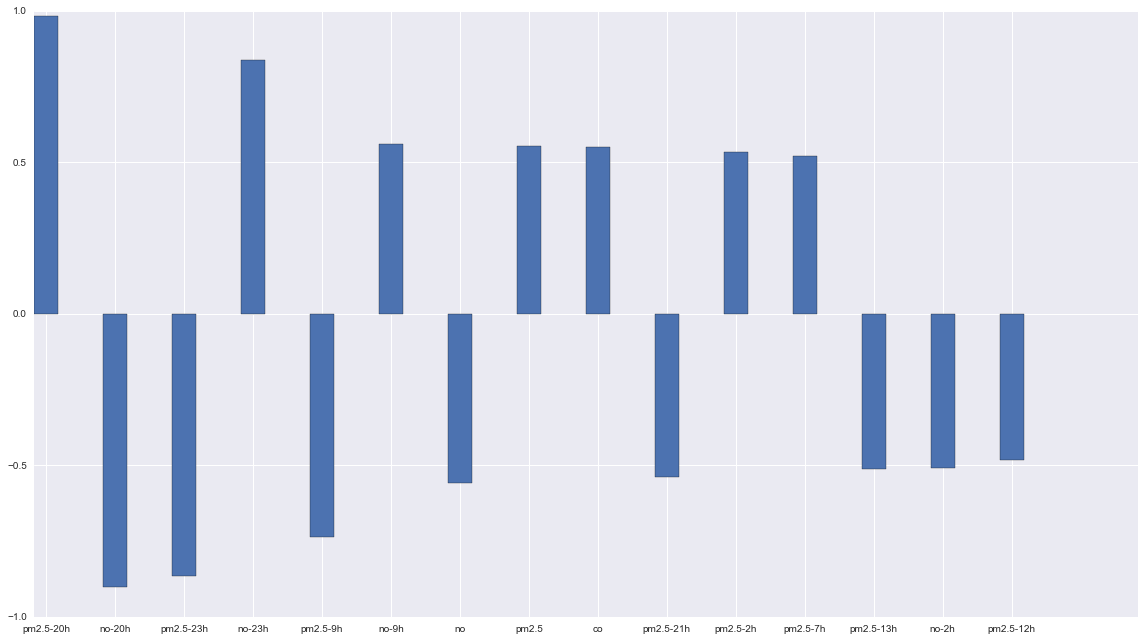

In [46]:
plot_dependency(models['co'], features)